# Laboratorio # 3

- Juan Luis Solórzano
- Diego Alonzo
- Arturo Argueta

In [1]:
import cv2
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

## 1. Preprocesamiento de la imagen

In [2]:
def preprocess_image(image: np.ndarray, k: int, output_dtype=np.uint8) -> np.ndarray:
    if k < 1:
        raise ValueError("El valor de k debe ser mayor o igual a 1.")
    
    # Redimensionar la imagen al tamaño (128k, 64k)
    new_size = (int(128 * k), int(64 * k))
    resized_image = resize(image, new_size, anti_aliasing=True)
    
    # Convertir a formato de salida
    if output_dtype == np.uint8:
        resized_image = (resized_image * 255).astype(np.uint8)
    elif output_dtype == np.float32:
        resized_image = resized_image.astype(np.float32)
    else:
        raise ValueError("Tipo de salida no soportado. Use np.uint8 o np.float32.")
    
    return resized_image

In [3]:
# Ejemplo de uso:
image = cv2.imread('person2.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
processed_image = preprocess_image(image_gray, k=3, output_dtype=np.uint8)

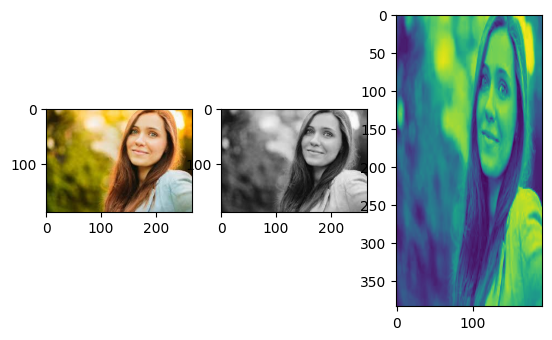

In [4]:
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(processed_image)

## 2. Prewitt o Sobel

In [5]:
def compute_gradient(image: np.ndarray, method: str = 'sobel'):
    if method.lower() == 'sobel':
        kernel_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        kernel_y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    elif method.lower() == 'prewitt':
        kernel_x = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        kernel_y = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    else:
        raise ValueError("Método no válido. Usa 'sobel' o 'prewitt'")
    
    # Aplicar padding para mantener el tamaño de la imagen
    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    
    # Aplicar correlación con los kernels
    Gx = cv2.filter2D(padded_image, -1, kernel_x)[1:-1, 1:-1]
    Gy = cv2.filter2D(padded_image, -1, kernel_y)[1:-1, 1:-1]
    
    # Calcular magnitud del gradiente
    magnitude = np.sqrt(Gx**2 + Gy**2)
    
    # Calcular ángulo del gradiente
    theta = np.arctan2(-Gy, Gx) * (180 / np.pi) % 180  # Modulo 180
    
    return magnitude, theta

In [6]:
image_sobel_mu, image_sobel_theta = compute_gradient(processed_image, "sobel")
image_prewitt_mu, image_prewitt_theta = compute_gradient(processed_image, "prewitt")

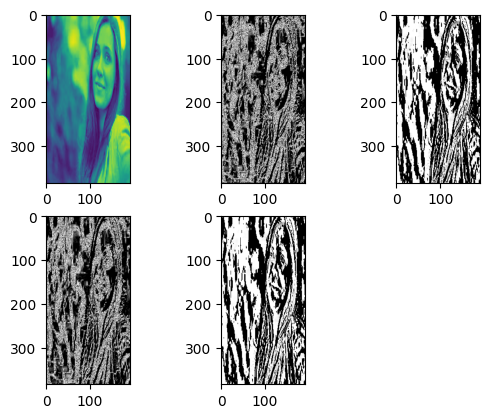

In [7]:
plt.subplot(2, 3, 1)
plt.imshow(processed_image)
plt.subplot(2, 3, 2)
plt.imshow(image_sobel_mu, cmap="gray")
plt.subplot(2, 3, 3)
plt.imshow(image_sobel_theta, cmap="gray")
plt.subplot(2, 3, 4)
plt.imshow(image_prewitt_mu, cmap="gray")
plt.subplot(2, 3, 5)
plt.imshow(image_prewitt_theta, cmap="gray")

## 3. Stack de bloques

In [8]:
def extract_blocks(mu, theta, block_size):
    stride = block_size // 2
    height, width = mu.shape
    
    M = (128 * height) // stride - 1
    N = (64 * width) // stride - 1
    
    blocks_mu = np.zeros((M, N, block_size, block_size), dtype=mu.dtype)
    blocks_theta = np.zeros((M, N, block_size, block_size), dtype=theta.dtype)
    
    for i in range(M):
        for j in range(N):
            y = i * stride
            x = j * stride
            if y + block_size <= height and x + block_size <= width:
                blocks_mu[i, j] = mu[y:y+block_size, x:x+block_size]
                blocks_theta[i, j] = theta[y:y+block_size, x:x+block_size]
    
    return blocks_mu, blocks_theta


In [9]:
array_sobel_mu, array_sobel_theta = extract_blocks(image_sobel_mu, image_sobel_theta, 32)
array_prewitt_mu, array_prewitt_theta = extract_blocks(image_prewitt_mu, image_prewitt_theta, 32)